# imports


In [1]:
import numpy as np
import pandas as pd
import warnings
import seaborn as sns
import pickle
from tools import get_mids
from matplotlib.colors import LogNorm
from matplotlib.gridspec import GridSpec
matplotlib = sns.mpl
plt = matplotlib.pyplot
plt.style.use("../style.mplstyle")
warnings.filterwarnings("ignore")

Could not import healpy.
functions plot_area, add_catalog, and add_extended_plane will not work.


In [2]:
from scipy.interpolate import RegularGridInterpolator

# loading effective areas


In [3]:
sindec_bins, logE_bins, aeffs = pd.read_pickle("../resources/aeff_cluster_nuecc_with-eq.pickle")


## binning

In [4]:
aeff = aeffs.iloc[0]["equatorial"] # for testing
logE_mids = get_mids(logE_bins)
ebins = np.power(10, logE_bins)
emids = get_mids(ebins)
ewidth = np.diff(ebins)
sindec_mids = get_mids(sindec_bins)
sindec_width = np.diff(sindec_bins)

print(len(emids), "log_10(energy) bins")
print(len(sindec_mids), "declination bins")

40 log_10(energy) bins
39 declination bins


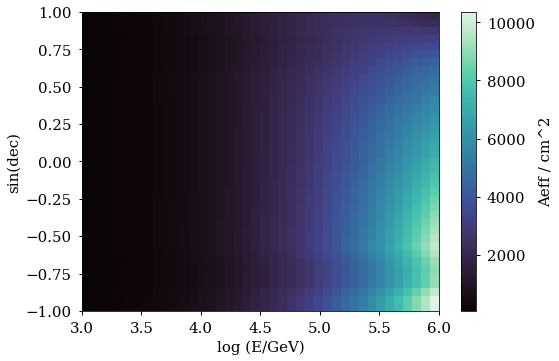

In [5]:
plt.pcolormesh(logE_bins, sindec_bins, aeff.T)
plt.xlabel("log (E/GeV)")
plt.ylabel("sin(dec)")
cb = plt.colorbar()
cb.set_label("Aeff / cm^2")


# background

In [25]:
# MCEQ
with open("../resources/MCEq_flux.pckl", "rb") as f:
    (e_grid, zen), flux_def = pickle.load(f)
rgi = RegularGridInterpolator(
    (e_grid, -np.cos(np.deg2rad(zen))), np.log(flux_def["nue_total"] + flux_def["nutau_pr"])
)
ee, ss = np.meshgrid(emids, sindec_mids)
spl_vals = np.exp(rgi((ee, ss)))

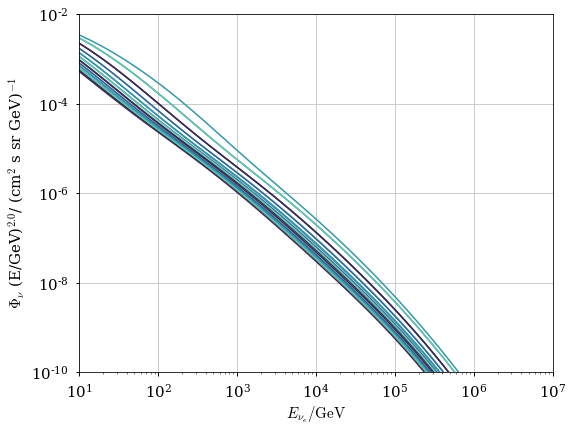

In [26]:
spec = 2.0
fig, ax = plt.subplots(figsize=(8, 6))
for ti, ang in enumerate(zen):
    p0 = ax.loglog(
        e_grid,
        e_grid ** (spec) * flux_def["nue_conv"][:, ti],
        ls="solid",
        lw=1.5,
    )

ax.set_xlim(10, 1e7)
ax.set_ylim(1e-10, 1e-2)
ax.set_xlabel(r"$E_{{{0}}} / {{\rm GeV}}$".format(r"\nu_e"))
ax.set_ylabel(
    r"$\Phi_{\nu}$ (E/GeV)$^{" + str(spec) + " }$" + "/ (cm$^{2}$ s sr GeV)$^{-1}$"
)
fig.tight_layout()


# energy resolution

In [27]:
eres_df = pd.read_pickle("../resources/optimization_resolutions.pickle")

# NGC1068 - source parameters

In [28]:
from settings import ngc1068

In [29]:
def array_source_interp(dec, array):
    low_ind = np.digitize(np.sin(dec), sindec_bins) - 1

    if low_ind >= (len(sindec_mids)-1):
        array_interp = array[:, -1]
    elif low_ind == 0:
        array_interp = array[:, low_ind]
    else:
        if sindec_mids[low_ind] > np.sin(dec):
            low_ind -= 1
        array_interp = np.zeros(len(array))
        for i in range(len(array)):
            array_interp[i] = np.interp(
                np.sin(dec),
                [sindec_mids[low_ind], sindec_mids[low_ind + 1]],
                [array[i, low_ind], array[i, low_ind + 1]],
            )
    return array_interp


In [32]:
# livetime of 10yr in seconds
LIVETIME = 365 * 10 * 24 * 3600
# 10yr PS PAPER PARAMETERS
GAMMA_NGC = 3.2
PHI_NGC = 5E-14 * 2 # numu + numubar -> nue+nuebar + nutau+nutaubar
E0_NGC = 1E3

# ngc flux error contour
gamma_c_68, phi_c_68 = np.loadtxt("../resources/ngc_paper_68_contour.txt")
phi_c_68 /= 1E11
# gamma_c_68, phi_c_68 = np.loadtxt("../resources/tenyr_paper_68_contour.txt")

# analysis region in distance to source
delta_psi = 2

In [33]:
from fluxes import astro_flux

## calculate number of events for ngc-like source

In [34]:
n_events = []
for aeff in aeffs["equatorial"]:
    aeff_factor_signal = (
        array_source_interp(ngc1068.dec.rad, aeff) * LIVETIME * ewidth
    )
    k_s = astro_flux(
        "powerlaw",
        aeff_factor_signal,
        emids,
        E0_NGC,
        GAMMA_NGC,
        1,
        phi_0=PHI_NGC,
        smear_energy=False,
    )
    n_events.append(np.sum(k_s))
    if n_events[-1] < 0:
        print(np.count_nonzero(aeff < 0))

aeffs["events_ngc"] = n_events


In [ ]:
n_events = []
for i, row in :
    aeff_factor_signal = (
        array_source_interp(ngc1068.dec.rad, aeff) * LIVETIME * ewidth * 2  # nu+nubar
    )
    k_s = astro_flux(
        "powerlaw",
        aeff_factor_signal,
        emids,
        E0_NGC,
        GAMMA_NGC,
        1,
        phi_0=PHI_NGC,
        smear_energy=False
    )
    n_events.append(np.sum(k_s))
    if n_events[-1] < 0:
        print(np.count_nonzero(aeff<0))

aeffs["events_ngc"] = n_events


<AxesSubplot:xlabel='events_ngc', ylabel='module_threshold'>

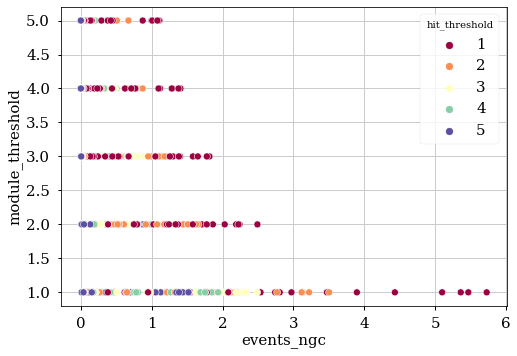

In [35]:
sns.scatterplot(
    data=aeffs.reset_index(),
    x="events_ngc",
    y="module_threshold",
    hue="hit_threshold",
    palette="Spectral",
)


# number of background events

In [36]:
from fluxes import atmo_background

In [38]:
delta_psi = 2
n_bckg = []
for aeff in aeffs["equatorial"]:
    aeff_factor_bckg = (
        array_source_interp(ngc1068.dec.rad, aeff)
        * LIVETIME
        * ewidth
        * (np.deg2rad(delta_psi) ** 2)
        * np.pi  # solid angle approx.
    )
    k_b = atmo_background(
        aeff_factor_bckg,
        array_source_interp(ngc1068.dec.rad, spl_vals.T).T,
        smear_energy=False,
    )
    n_bckg.append(np.sum(k_b))
aeffs["events_ngc_bckg"] = n_bckg

<AxesSubplot:xlabel='events_ngc_bckg', ylabel='module_threshold'>

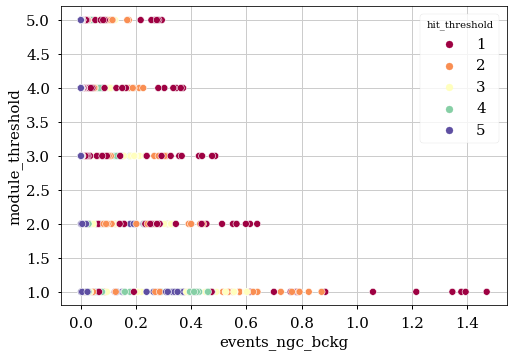

In [39]:
sns.scatterplot(
    data=aeffs.reset_index(),
    x="events_ngc_bckg",
    y="module_threshold",
    hue="hit_threshold",
    palette="Spectral",
)